In [230]:
import pyspark
from operator import add, itemgetter
import json
from string import punctuation
import math
from pyspark.conf import SparkConf
from string import punctuation
import matplotlib.pyplot as plt
#from nltk.stem import LancasterStemmer

# Calculating count of words in all docs combined

In [159]:
sc = pyspark.SparkContext('local[*]',appName="DocClassification")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=DocClassification, master=local[*]) created by __init__ at <ipython-input-2-62ec7fc213ec>:1 

In [160]:
documents = sc.textFile("/Volumes/OSX-DataDrive/data-distributed/dataset/training_set/X_train_vsmall.txt")

In [161]:
labels = sc.textFile("/Volumes/OSX-DataDrive/data-distributed/dataset/label_set/y_train_vsmall.txt")

In [162]:
splt = documents.flatMap(lambda word: word.split())
splt = splt.map(lambda word: word.lower())

#Removing Punctuation
splt = splt.map(lambda word: word.replace("&quot;",""))
splt = splt.map(lambda word: word.replace("&amp;",""))
cleanWords = splt.map(lambda word: word.strip(punctuation))
cleanWords = cleanWords.filter(lambda word:len(word)>2)

#Removing StopWord
stopWordFile = sc.textFile("/Volumes/OSX-DataDrive/data-distributed/stopwords.txts")
stopWord = sc.broadcast(stopWordFile.collect())
lessWords = cleanWords.filter(lambda x: x not in stopWord.value)

In [163]:
word = cleanWords.map(lambda word : (word,1))

In [164]:
CountinAllDocs = word.reduceByKey(add)

In [165]:
CountinAllDocs = CountinAllDocs.sortBy(lambda x: x[1],False)

In [166]:
numWords = sc.broadcast(CountinAllDocs.count())
numDocs = sc.broadcast(documents.count())
wordList = sc.broadcast(CountinAllDocs.keys().collect())

# Calculating term frequency in each doc

In [167]:
def stripWord(x):
    tempList =[]
    for word in x:
        word = word.lower()
        word = word.replace("&quot","")
        word = word.replace("&amp","")
        word = word.strip(punctuation)
        if len(word)>2:
            tempList.append(word)
    return tempList

In [168]:
def stripStopWord(x):
    tempList =[]
    for word in x:
        if word not in stopWord.value:
            tempList.append(word)
    return tempList

In [169]:
def countWord(x):
    dictionary={}
    for word in x:
        if word not in dictionary:
            dictionary[word] = 1
        else:
            dictionary[word]+=1
    return dictionary

In [203]:
bagOfWords = documents.map(lambda word: word.split())
bagOfWords = bagOfWords.map(lambda x: stripWord(x))
#bagOfWords = bagOfWords.map(lambda x: stripStopWord(x))
tf = bagOfWords.map(lambda x: countWord(x))

# Calculating idf

In [204]:
def uniques(x):
    tempList=[]
    for word in x:
        if word not in tempList:
            tempList.append(word);
    return tempList

In [205]:
uniqueList = tf.map(lambda x: uniques(x))

In [206]:
def initializeMap(x):
    tempList = []
    for word in x:
        tempList.append((word,1))
    return tempList

In [207]:
occurences = uniqueList.map(lambda x: initializeMap(x)).flatMap(lambda x: x).reduceByKey(add)

In [208]:
idf = occurences.map(lambda x: (x[0],math.log(numDocs.value/float(x[1]))))

In [209]:
idf2 = sc.broadcast(idf.collectAsMap())

# Calculating Tf-idf

In [210]:
def getTfidf(x):
    tempDict={}
    idfDict=idf2.value
    for k,v in x.items():
        tempDict[k] = v*idfDict[k]
    return tempDict

In [211]:
tfidf = tf.map(lambda x: getTfidf(x) )

In [212]:
tfidfSorted = tfidf.map(lambda x: sorted(x.items(), key=itemgetter(1), reverse = True))

# Implementing Naive Bayes

## Calculating word probability

In [213]:
spltLabels = labels.map(lambda word: word.split(","))

In [214]:
def removeUnnecessary(label):
    tempList=[]
    for word in label:
        if 'CAT' in word:
            tempList.append(word)
    return tempList

In [215]:
requiredLabels = spltLabels.map(lambda label: removeUnnecessary(label))

In [216]:
numberOfDocs = sc.broadcast(requiredLabels.flatMap(lambda x: x).count())

In [217]:
labelsToUse = sc.broadcast(requiredLabels.collect())

In [218]:
def dictToList(x):
    tempList=[]
    for k, v in x.items():
        tempList.append((k,v))
    return tempList

In [219]:
def getProbDoc(x,v):
    tempDict={}
    for label in labelsToUse.value[v]:
        tempDict[label] = x
    return tempDict

In [220]:
ProbDocIndex = tfidfSorted.zipWithIndex()

In [221]:
def totalTfidf(x):
    total =0
    for k,v in x.items():
        total = total+v
    return total

In [222]:
ProbDoc = ProbDocIndex.map(lambda x: getProbDoc(x[0],x[1]))

In [223]:
ProbDocIndex.collect()[0][0]

[('weather', 21.097538525880534),
 ('equipment', 14.105442098464646),
 ('snow', 12.658523115528322),
 ('airports', 10.579081573848484),
 ('each', 10.440279170968026),
 ('authority', 9.36268624952399),
 ('dedicated', 8.439015410352214),
 ('port', 8.439015410352214),
 ('winter', 8.439015410352214),
 ('cargo', 7.052721049232323),
 ('newark', 7.052721049232323),
 ('airport', 7.052721049232323),
 ('desk', 6.241790833015994),
 ('reports', 6.241790833015994),
 ('key', 5.666426688112432),
 ('operations', 5.666426688112432),
 ('air', 5.666426688112432),
 ('and', 5.227239895715332),
 ('171', 5.220139585484013),
 ('542', 5.220139585484013),
 ('react', 4.219507705176107),
 ('harsh', 4.219507705176107),
 ('prevent', 4.219507705176107),
 ('disruption', 4.219507705176107),
 ('travellers', 4.219507705176107),
 ("york's", 4.219507705176107),
 ('kennedy', 4.219507705176107),
 ('laguardia', 4.219507705176107),
 ('carefully', 4.219507705176107),
 ('patterns', 4.219507705176107),
 ('supplements', 4.2195077

In [224]:
ProbDocList= ProbDoc.map(lambda x : dictToList(x))

In [225]:
def tfidfListToDict(x):
    tempDict={}
    for word in x:
        tempDict[word[0]] = word[1]
    return tempDict

In [240]:


def plot_histogram(dataset,top=10):
    for i in range(0,len(dataset)):
        class_entry = dataset[i][1]
        print(dataset[i][0])
        float_values = [(i[0],float(i[1])) for i in class_entry][:top]
        plt.hist(float_values)
        plt.show()

    

In [227]:
ProbDocList = ProbDocList.flatMap(lambda x: x).reduceByKey(add)
ProbDocDict= ProbDocList.map(lambda x: (x[0],tfidfListToDict(x[1])))

In [228]:
ProbDocDictSorted = ProbDocDict.map(lambda x: (x[0],sorted(x[1].items(), key=itemgetter(1), reverse = False)))
result = ProbDocDictSorted.collect()

CCAT


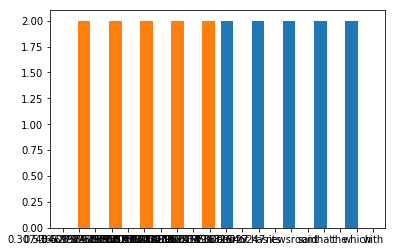

GCAT


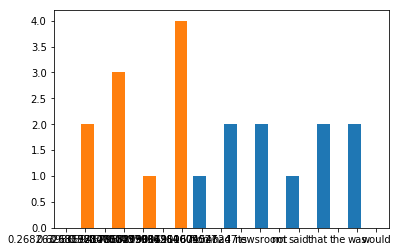

MCAT


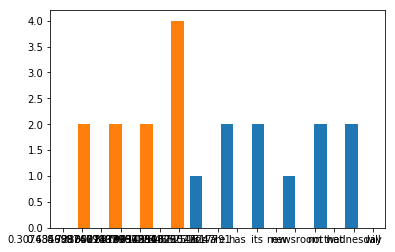

ECAT


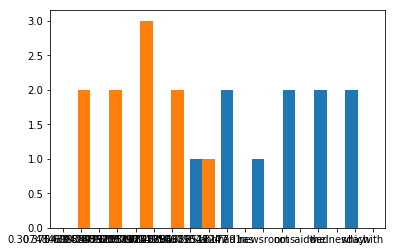

In [241]:
plot_histogram(result)

# Above Code for class wise tfidf and stopwords

In [111]:
def getOurStopwords(x):
    tempList=[]
    for word in x:
        if(word[1]<3.0):
            tempList.append(word[0])
    return tempList

In [112]:
ourStopwords = ProbDocDictSorted.map(lambda x: getOurStopwords(x[1]))

In [113]:
toDownload = ourStopwords.flatMap(lambda x: x).distinct()

In [114]:
rd = toDownload.collect()

In [117]:
result = open('ourStopwords.txt', 'w')
for td in rd:
    result.write("%s\n" % td)

In [37]:
labelWC = ProbDocDict.map(lambda x: (x[0],totalTfidf(x[1])))
labelWordCount =sc.broadcast(labelWC.collectAsMap())

In [38]:
def addAllwords(x):
    tempDict=x[1]
    for word in wordList.value:
        if word not in x[1]:
            tempDict[word] = 0
    return (x[0],tempDict)

In [39]:
ProbDocDictAll = ProbDocDict.map(lambda x: addAllwords(x))

In [40]:
def getWordProbability(x):
    tempDict={}
    for k,v in x[1].items():
        tempDict[k]= (v+0.1)/float(0.1*numWords.value + labelWordCount.value[x[0]])
    return (x[0],tempDict)

In [41]:
wordProbability = ProbDocDictAll.map(lambda x: getWordProbability(x))

In [42]:
def getLogProb(x):
    tempDict= {}
    for k,v in x[1].items():
        tempDict[k] = math.log(v)
    return (x[0],tempDict)

In [43]:
logProbability = wordProbability.map(lambda x: getLogProb(x))

## Calculating Class Probability

In [44]:
classList = requiredLabels.flatMap(lambda x: x)
classCount = classList.map(lambda x: (x,1)).reduceByKey(add)

In [45]:
classProbability = classCount.map(lambda x: (x[0],math.log(x[1]/float(numberOfDocs.value))))
classProb = sc.broadcast(classProbability.collectAsMap())

## Testing the probabilities

In [46]:
sums=0
for k,v in wordProbability.collect()[0][1].items():
    sums = sums+v
print(sums)

1.0000044555281526


#  Prediction

In [47]:
testDocuments = sc.textFile("/Volumes/OSX-DataDrive/data-distributed/dataset/training_set/X_test_vsmall.txt")
testLabels = sc.textFile("/Volumes/OSX-DataDrive/data-distributed/dataset/label_set/y_test_vsmall.txt")

In [48]:
bagOfWordsTest = testDocuments.map(lambda word: word.split())
bagOfWordsTest = bagOfWordsTest.map(lambda x: stripWord(x))
#bagOfWordsTest = bagOfWordsTest.map(lambda x: stripStopWord(x))

In [49]:
testData = sc.broadcast(bagOfWordsTest.collect())

In [61]:
def TestLogProbSum(x):
    tempDict={}
    for i in range(len(testData.value)):
        logSum=0;
        for word in testData.value[i]:
            if word in x[1]:
                logSum=logSum+x[1][word]
            else:
                logSum = logSum+ math.log((0.1/0.1*float(numWords.value)))
        tempDict[i]= logSum
    return (x[0],tempDict)

In [62]:
logProbSum = logProbability.map(lambda x: TestLogProbSum(x))

In [63]:
def getPrediction(x):
    tempDict={}
    for k,v in x[1].items():
        tempDict[k]= v+classProb.value[x[0]]
    return(x[0],tempDict)

In [64]:
prediction = logProbSum.map(lambda x: getPrediction(x))

In [65]:
def dictToTupple(x):
    tempList=[]
    for k, v in x[1].items():
        tempList.append((k,(x[0],v)))
    return tempList

In [66]:
predictComparison = prediction.map(lambda x: dictToTupple(x)).flatMap(lambda x: x).reduceByKey(add)

In [67]:
def getPrediction(x):
    tempList = []
    for i in x:
        if type(i) == float:
            tempList.append(i)
    return x[tempList.index(max(tempList))*2]

In [68]:
predictedLabel = predictComparison.map(lambda x: getPrediction(x[1]))
predicted = predictedLabel.collect()

In [69]:
correctLabel = testLabels.collect()

In [70]:
count = 0
for i in range(len(predicted)):
    if predicted[i] in correctLabel[i]:
        count = count+1
accuracy = count/float(len(predicted))
print(accuracy)

0.3422982885085575


In [60]:
result = open('y_test_small_prediction.txt', 'w')
for labels in predicted:
    result.write("%s\n" % labels)